<a href="https://colab.research.google.com/github/SteevyG1350/backtest/blob/main/holygrail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload your OHLCV CSV file (MT5 or broker export):


Saving XAUUSD_historical_data(2).csv to XAUUSD_historical_data(2) (10).csv
Uploaded file: XAUUSD_historical_data(2) (10).csv
Starting Capital: 5000
Ending Capital: 6016.95
Total Trades: 55
Win Rate: 65.45%
Max Drawdown: 150.66 (2.48%)
Profit Factor: 2.01
Annualized Sharpe: 1.32


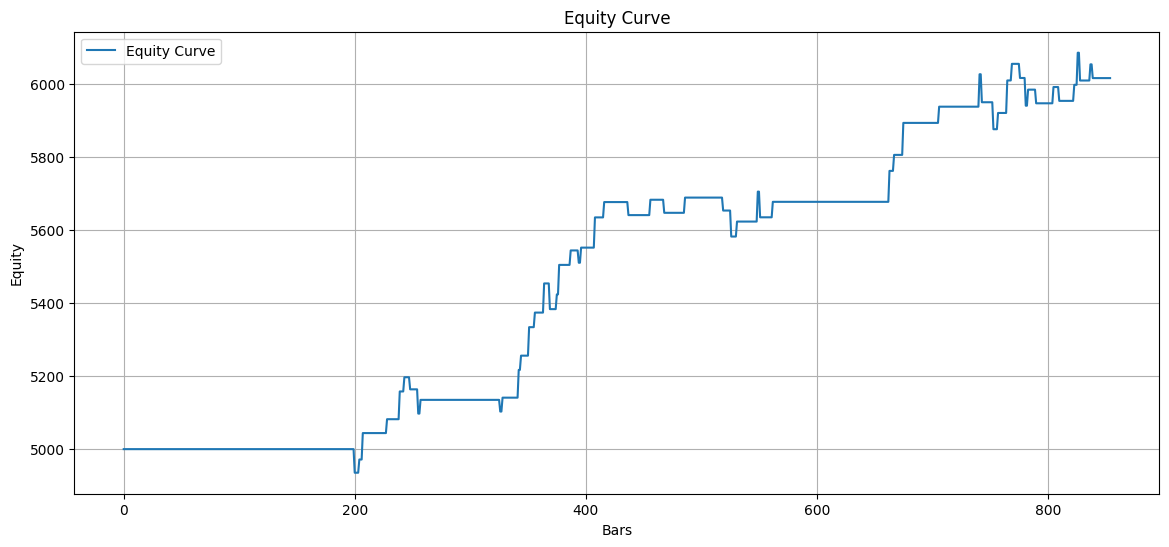

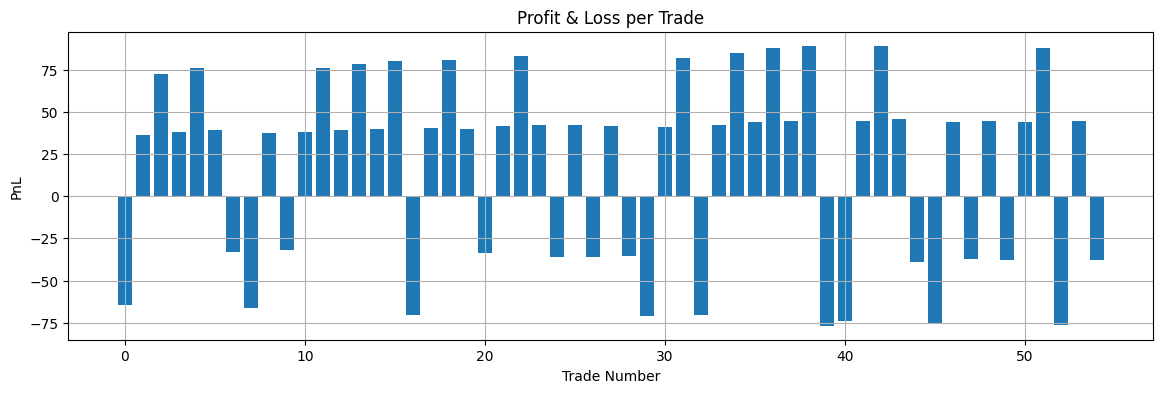

Trades exported to trades_output.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
# --------------------- SINGLE-CELL ENHANCED TRADING SYSTEM ---------------------
!pip install pandas==2.2.2 pandas-ta matplotlib --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from difflib import get_close_matches

# ------------------ Upload CSV ------------------
print("Upload your OHLCV CSV file (MT5 or broker export):")
uploaded = files.upload()
if uploaded:
    filename = next(iter(uploaded))
    print(f"Uploaded file: {filename}")

# ------------------ Load CSV with auto column matching ------------------
raw_df = pd.read_csv(filename)
expected_cols = ['Date','open','high','low','close','Change(Pips)','change(%)']
df = raw_df.copy()

col_map = {}
for exp_col in expected_cols:
    match = get_close_matches(exp_col.lower(), [c.lower() for c in df.columns], n=1)
    if match:
        col_map[match[0]] = exp_col
df.rename(columns=col_map, inplace=True)

if 'Date' in df.columns:
    df['datetime'] = pd.to_datetime(df['Date'])
    df.set_index('datetime', inplace=True)

df = df[['open','high','low','close']].dropna()

# ------------------ Indicators ------------------
df['SMA_21'] = df['close'].rolling(21).mean()
df['SMA_50'] = df['close'].rolling(50).mean()
df['SMA_200'] = df['close'].rolling(200).mean()

tolerance = 0.001
df['long_signal'] = ((df['SMA_21'] > df['SMA_50']*(1-tolerance)) & (df['SMA_50'] > df['SMA_200']*(1-tolerance)))
df['short_signal'] = ((df['SMA_21'] < df['SMA_50']*(1+tolerance)) & (df['SMA_50'] < df['SMA_200']*(1+tolerance)))

# ------------------ Backtest Function ------------------
def run_backtest(df, atr_mult_sl=2, atr_mult_tp=3, risk_pct=0.01, starting_capital=10000):
    equity = starting_capital
    equity_curve = [equity]
    position = None
    ATR_len = 14
    partial_exit = True
    partial_pct = 0.5
    commission = 0.0
    slippage = 0.0
    trades = []

    # ATR calculation
    df['tr0'] = df['high'] - df['low']
    df['tr1'] = abs(df['high'] - df['close'].shift())
    df['tr2'] = abs(df['low'] - df['close'].shift())
    df['TR'] = df[['tr0','tr1','tr2']].max(axis=1)
    df['ATR'] = df['TR'].rolling(ATR_len).mean()

    for i in range(1,len(df)):
        row = df.iloc[i]
        if position is None:
            if row['long_signal']:
                sl = row['close'] - row['ATR']*atr_mult_sl
                tp = row['close'] + row['ATR']*atr_mult_tp
                qty = np.floor(equity*risk_pct / (row['ATR']*atr_mult_sl))
                if qty>0:
                    position = {'type':'long','entry':row['close'],'sl':sl,'tp':tp,'qty':qty,'partial':False,'entry_idx':i}
            elif row['short_signal']:
                sl = row['close'] + row['ATR']*atr_mult_sl
                tp = row['close'] - row['ATR']*atr_mult_tp
                qty = np.floor(equity*risk_pct / (row['ATR']*atr_mult_sl))
                if qty>0:
                    position = {'type':'short','entry':row['close'],'sl':sl,'tp':tp,'qty':qty,'partial':False,'entry_idx':i}
        else:
            # Position management: partial exits
            if position['type']=='long':
                if partial_exit and not position['partial']:
                    partial_tp = position['entry'] + (position['tp'] - position['entry'])*partial_pct
                    if row['high']>=partial_tp:
                        pnl = (partial_tp - position['entry'])*position['qty']*partial_pct
                        equity += pnl - commission - slippage
                        trades.append({'type':'long_partial','PnL':pnl,'entry_idx':position['entry_idx'],'exit_idx':i})
                        position['qty'] *= (1-partial_pct)
                        position['partial'] = True
                if row['low'] <= position['sl'] or row['high'] >= position['tp']:
                    exit_price = position['sl'] if row['low']<=position['sl'] else position['tp']
                    pnl = (exit_price - position['entry'])*position['qty']
                    equity += pnl - commission - slippage
                    trades.append({'type':'long','PnL':pnl,'entry_idx':position['entry_idx'],'exit_idx':i})
                    position = None
            elif position['type']=='short':
                if partial_exit and not position['partial']:
                    partial_tp = position['entry'] - (position['entry'] - position['tp'])*partial_pct
                    if row['low']<=partial_tp:
                        pnl = (position['entry']-partial_tp)*position['qty']*partial_pct
                        equity += pnl - commission - slippage
                        trades.append({'type':'short_partial','PnL':pnl,'entry_idx':position['entry_idx'],'exit_idx':i})
                        position['qty'] *= (1-partial_pct)
                        position['partial'] = True
                if row['high'] >= position['sl'] or row['low'] <= position['tp']:
                    exit_price = position['sl'] if row['high']>=position['sl'] else position['tp']
                    pnl = (position['entry'] - exit_price)*position['qty']
                    equity += pnl - commission - slippage
                    trades.append({'type':'short','PnL':pnl,'entry_idx':position['entry_idx'],'exit_idx':i})
                    position = None
        equity_curve.append(equity)
    return equity_curve, trades

# ------------------ Run Backtest with specified parameters ------------------
best_params = {
    'atr_mult_sl': 1.1531346901068218,
    'atr_mult_tp': 2.7106431045904475,
    'risk_pct': 0.012946641132390217
}

equity_curve, trades = run_backtest(df, best_params['atr_mult_sl'], best_params['atr_mult_tp'], best_params['risk_pct'], starting_capital=5000)
equity_series = pd.Series(equity_curve)
returns = equity_series.pct_change().dropna()

# ------------------ Performance metrics ------------------
df_index = df.index.drop_duplicates()
freq_sec = df_index.to_series().diff().mode()[0].total_seconds() if len(df_index)>1 else 252
bars_per_year = 31536000/freq_sec if freq_sec>0 else 252
sharpe = returns.mean()/returns.std()*np.sqrt(bars_per_year) if returns.std()!=0 else 0
rolling_max = equity_series.cummax()
drawdown = rolling_max - equity_series
max_dd = drawdown.max()
max_dd_pct = max_dd/rolling_max.max()*100 if rolling_max.max()>0 else 0
wins = [t['PnL'] for t in trades if t['PnL']>0]
losses = [-t['PnL'] for t in trades if t['PnL']<0]
profit_factor = sum(wins)/sum(losses) if sum(losses)>0 else np.nan

print(f"Starting Capital: 5000")
print(f"Ending Capital: {equity_series.iloc[-1]:.2f}")
print(f"Total Trades: {len(trades)}")
print(f"Win Rate: {len(wins)/len(trades)*100 if trades else 0:.2f}%")
print(f"Max Drawdown: {max_dd:.2f} ({max_dd_pct:.2f}%)")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Annualized Sharpe: {sharpe:.2f}")

# ------------------ Plot Equity & PnL ------------------
plt.figure(figsize=(14,6))
plt.plot(equity_series, label='Equity Curve')
plt.title('Equity Curve')
plt.xlabel('Bars')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14,4))
trade_pnl = [t['PnL'] for t in trades]
plt.bar(range(len(trade_pnl)), trade_pnl)
plt.title('Profit & Loss per Trade')
plt.xlabel('Trade Number')
plt.ylabel('PnL')
plt.grid(True)
plt.show()

# ------------------ Export trades ------------------
trades_df = pd.DataFrame(trades)
trades_df.to_csv('trades_output.csv', index=False)
print("Trades exported to trades_output.csv")
files.download('trades_output.csv')
